# Create new library designer function

Import data.

In [1]:
%load_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

load data


In [2]:
building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630.fpb')

# align fingerprints to building blocks
print('align fingerprints')
fingerprints = dg.utils.sort_fingerprints(fingerprints, building_blocks)

align fingerprints


Create inputs to the DrugEnv.

In [3]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle, DockingOracle
from dgym.envs.evaluator import ClassicEvaluator, UtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

Testing the best performing molecule from docking screen.

In [4]:
%%time
mol = dg.molecule.Molecule(
    'Cc1ccccc1C(=O)Nc1nc(-c2cccc(O)c2)cs1',
    reactants = [
        dg.molecule.Molecule('Cc1ccccc1C(=O)O'),
        dg.molecule.Molecule('Nc1nc(-c2cccc(O)c2)cs1'),
    ]
)

library_designer.reset_cache()

analogs = library_designer.design(
    molecule = deck[0],
    num_analogs = 20,
    temperature = 0.0
)
# [display(a) for a in analogs]

CPU times: user 104 ms, sys: 239 µs, total: 104 ms
Wall time: 103 ms


In [81]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle, DockingOracle
from dgym.envs.evaluator import ClassicEvaluator, UtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

# create docking oracle
config = {
    'center_x': 9.812,
    'center_y': -0.257,
    'center_z': 20.8485,
    'size_x': 30,
    'size_y': 30,
    'size_z': 30,
    'exhaustiveness': 128,
    'max_step': 20,
    'num_modes': 9,
    'scoring': 'vinardo',
    'refine_step': 3,
    'seed': 5
}

docking_oracle = DockingOracle(
    'Mpro affinity',
    receptor_path=f'{path}/Mpro_prepped.pdbqt',
    config=config
)

In [52]:
best_analog.reactants[1].smiles

'O=C(O)c1c(F)ccc(O)c1F'

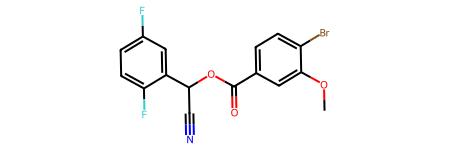

6.921561543699966


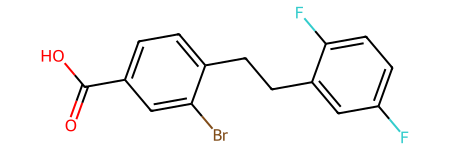

6.440669611907785


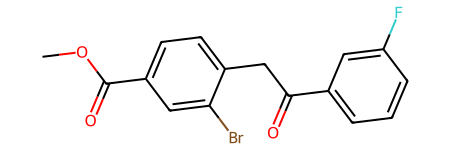

6.682275972162208


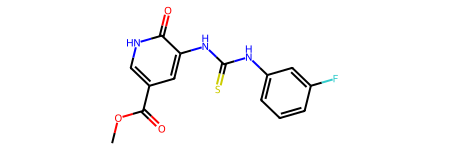

6.236119311929377


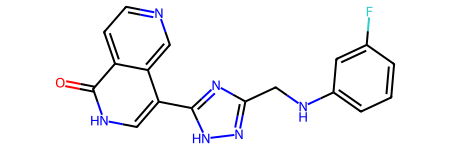

6.455900261225061


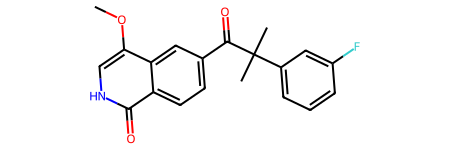

7.121678973925887


In [72]:
from tqdm.notebook import tqdm

library_designer.reset_cache()

# best_analog = dg.molecule.Molecule(
#     'Cc1ccccc1C(=O)Nc1nc(-c2cccc(O)c2)cs1',
#     reactants = [
#         dg.molecule.Molecule('Cc1ccccc1C(=O)O'),
#         dg.molecule.Molecule('Nc1nc(-c2cccc(O)c2)cs1'),
#     ]
# )
# display(best_analog)
# print(6.737014029700801)


best_analog = dg.molecule.Molecule(
    'COc1cc(C(=O)OC(C#N)c2cc(F)ccc2F)ccc1Br',
    reactants = [
        dg.molecule.Molecule('COc1cc(C(=O)O)ccc1Br'),
        dg.molecule.Molecule('N#CC(O)c1cc(F)ccc1F'),
    ]
)

display(best_analog)
print(6.921561543699966)

# best_analog = dg.molecule.Molecule(
#     'N#CN(C(=O)Cc1ccc2cn[nH]c2c1)c1cccc(C(=O)O)c1',
#     reactants = [
#         dg.molecule.Molecule('O=C(O)Cc1ccc2cn[nH]c2c1'),
#         dg.molecule.Molecule('N#CNc1cccc(C(=O)O)c1'),
#     ]
# )

# display(best_analog)
# print(7.123005139339721)

# best_analog = dg.molecule.Molecule(
#     'O=C(c1ccc2c(c1)CC2)c1cnc(F)c(C(=O)O)c1',
#     reactants = [
#         dg.molecule.Molecule('N#Cc1cnc(F)c(C(=O)O)c1'),
#         dg.molecule.Molecule('Brc1ccc2c(c1)CC2'),
#     ]
# )

# display(best_analog)
# print(7.244001238124934)


# best_analog = dg.molecule.Molecule(
#     'O=C(c1ccc2c(c1)CCCC2)c1ccc(F)c(C(=O)O)c1',
#     reactants = [
#         dg.molecule.Molecule('N#Cc1ccc(F)c(C(=O)O)c1'),
#         dg.molecule.Molecule('Brc1ccc2c(c1)CCCC2'),
#     ]
# )

# display(best_analog)
# print(7.462370863410115)

# best_analog = dg.molecule.Molecule(
#     'O=C(O)c1c(F)ccc(Oc2ccc3c(c2)CCNC3)c1F',
#     reactants = [
#         dg.molecule.Molecule('Brc1ccc2c(c1)CCNC2.Cl'),
#         dg.molecule.Molecule('O=C(O)c1c(F)ccc(O)c1F'),
#     ]
# )

# display(best_analog)
# print(7.66805169179407)



for _ in range(5):

    analogs = library_designer.design(
        molecule = best_analog,
        num_analogs = 50,
        temperature = 0.5
    )

    if analogs:
        
        results = docking_oracle(analogs)
        
        best = np.nanargmax(results).item()
        best_analog = analogs[best]
        best_result = results[best]
        
        display(best_analog)
        print(best_result)

In [86]:
docking_oracle([dg.molecule.Molecule('CN1CCN(CC1)S(=O)(=O)N1CC(C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc2C1')])

[5.155669372550421]

Testing docking.

In [232]:
df = pd.read_csv(
    f'{path}/COVID_moonshot_data_clean/cdd_noncovalent_dates_2023_10_18_filt.csv'
)
df = df[df.Semiquant == 'Quant']
df['pIC50'] = -np.log10(df['IC50_(µM)'].astype(float) / 1e6)
df = df[['suspected_SMILES', 'pIC50']]
df.columns = ['SMILES', 'pIC50']

In [235]:
moonshot = dg.collection.MoleculeCollection([
    dg.molecule.Molecule(s) for s in df['SMILES'].tolist()
])

In [238]:
%%time
results = docking_oracle(moonshot)

CPU times: user 1.48 s, sys: 0 ns, total: 1.48 s
Wall time: 13.1 s


In [241]:
df['dG'] = results

In [242]:
df

,SMILES,pIC50,dG
52,CNC(=O)CN1Cc2ccc(Cl)cc2[C@@]2(CCN(c3cncc4ccc(F...,7.066513,6.191978
53,CNC(=O)CN1Cc2ccc(Cl)cc2[C@]2(CCN(c3cncc4ccc(F)...,4.787812,6.000267
54,CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccc(Cl)cc34)C2=O)...,5.508638,5.194354
56,CN1CCC(Oc2ccc3cncc(N4CCC5(CN(S(=O)(=O)CC6(C#N)...,6.665546,4.009104
57,CNS(=O)(=O)N1Cc2ccc(Cl)cc2C2(CCN(c3cncc4ccccc3...,6.443697,6.180124
...,...,...,...
2141,"O=C(CC1=CN=CC2=CC=CC=C12)NC1=CC=CC=C1 |c:5,9,1...",4.212540,5.675934
2142,O=C(Nc1cccnc1)c1cc(Cl)ccc1-c1ccccc1,4.407823,5.804918
2143,O=C(Nc1cnccc1Cl)c1cc(Cl)ccc1O,4.616185,5.475818
2144,CN1N=NC=C1CC(=O)NC(C1=NC2=CC=CC=C2N1C)C1=CC=CC...,4.447332,5.940185


<>:6: DeprecationWarning: invalid escape sequence '\D'
<>:6: DeprecationWarning: invalid escape sequence '\D'
/tmp/ipykernel_76570/711668822.py:6: DeprecationWarning: invalid escape sequence '\D'
  g.set_xlabel('Predicted $\Delta$G')


Text(0.5, 0, 'Predicted $\\Delta$G')

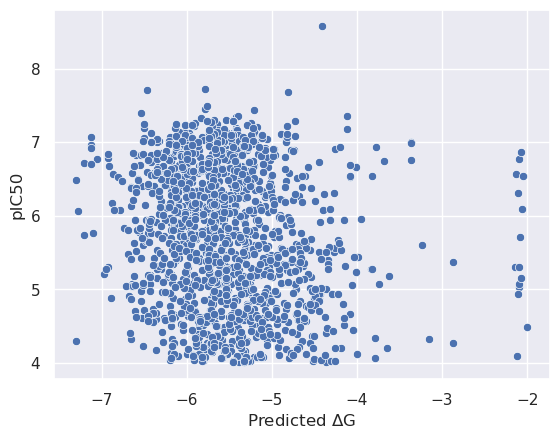

In [244]:
g = sns.scatterplot(
    y=df['pIC50'],
    x=[-r for r in results]
)

g.set_xlabel('Predicted $\Delta$G')